<a href="https://colab.research.google.com/gist/KhawajaMuddassar/0c68164efad2104d8dff7f398a1418b8/facegeneration-dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Face Image Generation Using DCGAN:**

Deep Convolutional Generative Adversarial Networks (DCGANs) are a powerful extension of the original Generative Adversarial Network (GAN) framework, designed specifically to enhance image generation tasks. By utilizing convolutional neural networks (CNNs), DCGANs are capable of generating highly realistic images, making them one of the most popular architectures in generative models. DCGANs have been successfully applied in various domains, including image synthesis, data augmentation, and creative applications such as art generation.

**GAN structure:**
The fundamental idea of GANs is a competitive minimax game between the generator model, G, and the discriminator model, D.the two networks are to be trained in tandem until a Nash equilibrium is reach for the objective of generating quality synthetic data; the data generated by G is significantly alike to the training data that D cannot differentiate the synthetic data from the genuine data.

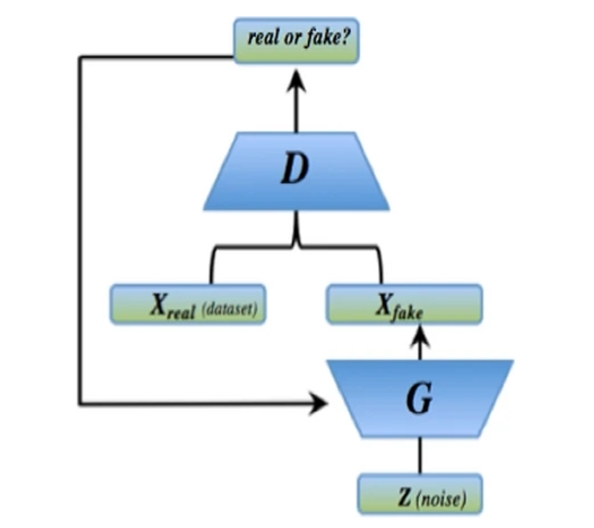

The generator model, G, is passed a uniform random noise distribution (z), and manipulates it during training, G(z), to mirror the target distribution. The generator model is trained to maximize the projected log-probability with which the discriminator model distinguishes G(z) as a real sample. The discriminator model, D, is passed an array of unlabeled samples from G(z) and the real data distribution, pr. The discriminator is trained to distinguish between the generated, synthetic samples, and real samples.This match between G and D forms a minimax game where the loss function is mutually maximized by the discriminator and minimized by the generator

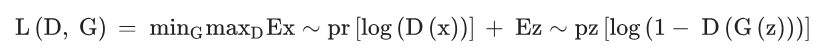

**DCGAN architecture:**To improve the quality of synthetic generation, specifically for images, the GAN technique was paired with Convolutional Neural Networks (CNNs). CNNs are know for is successes in computer vision techniques involving images recognition.

The DCGANs architecture was pioneered to diminish the mode collapse dilemma in GANs. **Mode collapse** arises when the generator develops bias towards a few outputs and fails to produce unique outputs of each variation from the dataset.

**Key Components of DCGANs**A DCGAN consists of two main components as follows:
* **Generator:**The generator takes a random noise vector (latent vector) as input and generates synthetic images. The goal of the generator is to learn how to produce images that resemble real images from the dataset.

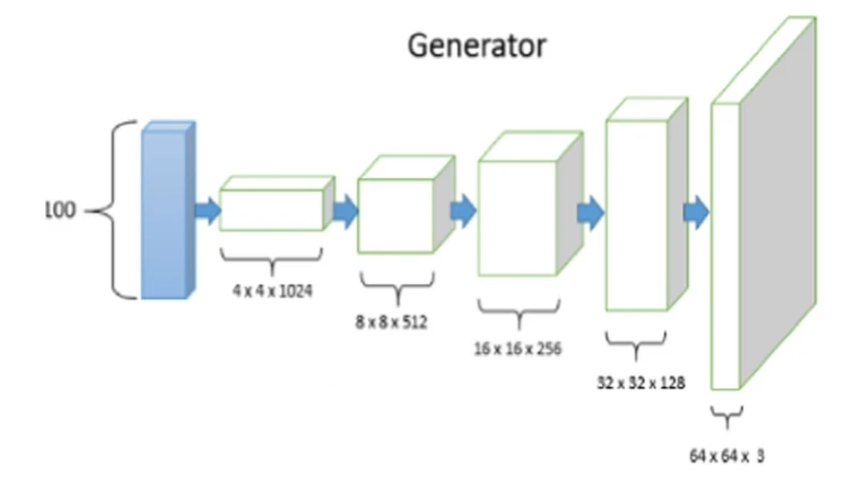

* **Discriminator:**The discriminator is a binary classifier that distinguishes between real images (from the dataset) and fake images (generated by the generator). Its purpose is to provide feedback to the generator about how realistic the generated images are.

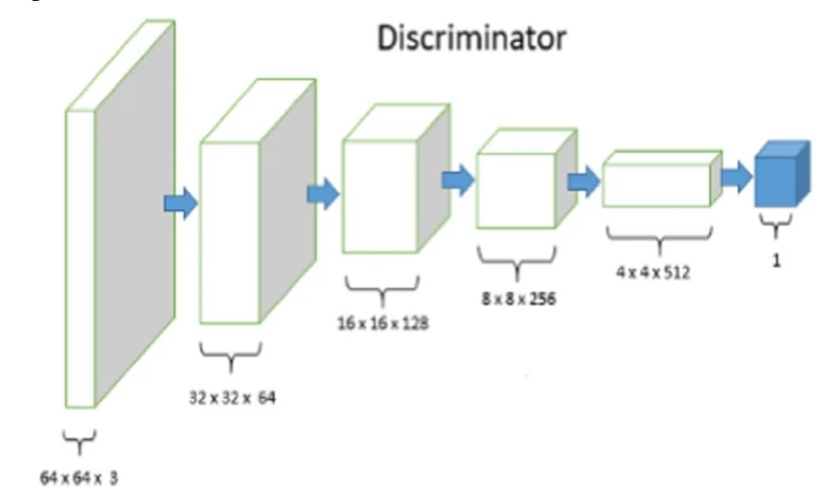

**DCGAN framework:**
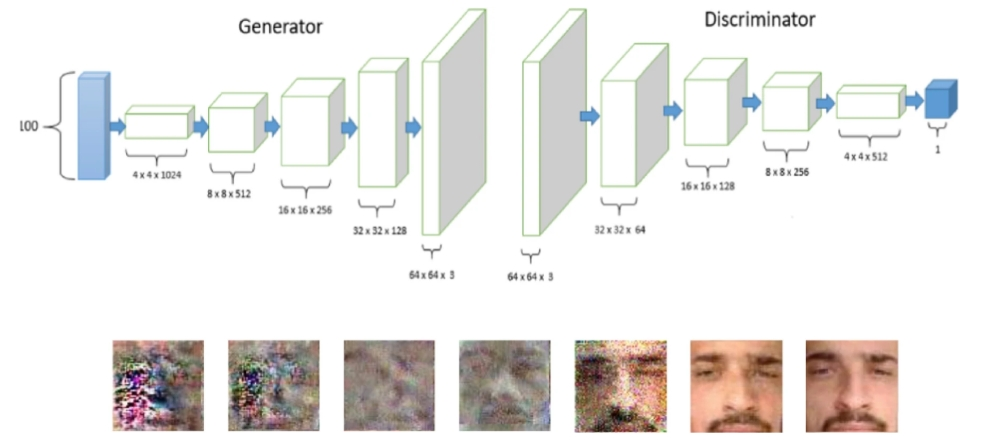


In [ ]:
!pip install -q --upgrade torch_snippets gdown torchsummary
import os, gdown, zipfile, shutil, torch, torchvision, cv2, numpy as np, pandas as pd
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch_snippets.paths import Glob
from PIL import Image
import torch.optim as optim
from torch_snippets.loader import read, Tqdm, show
from torch_snippets.torch_loader import Report
import torchvision.utils as vutils
import torch.nn as nn
from torchsummary import summary
device = 'cuda' if torch.cuda.is_available() else 'cpu'



Discriminator Model Summary:

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,072
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,288
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,664
      BatchNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
           Conv2d-12              [-1, 1, 1, 1]           8,192
          Sigmoid-13              [-1, 1, 1, 1]               0
Total pa

100%|██████████| 251/251 [00:00<00:00, 770.14it/s]


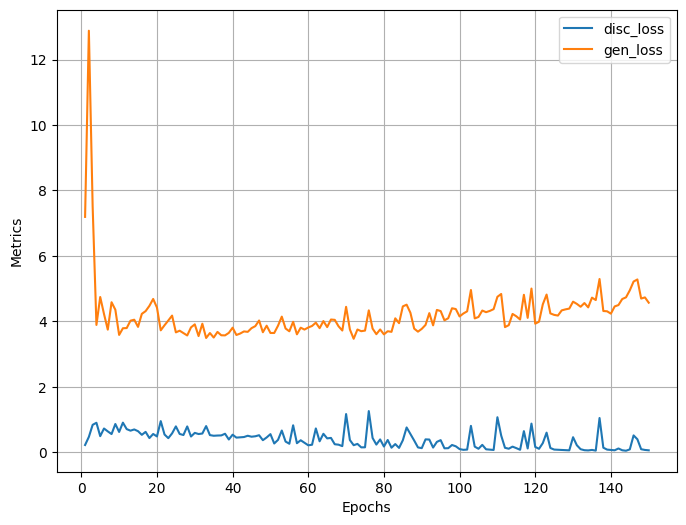

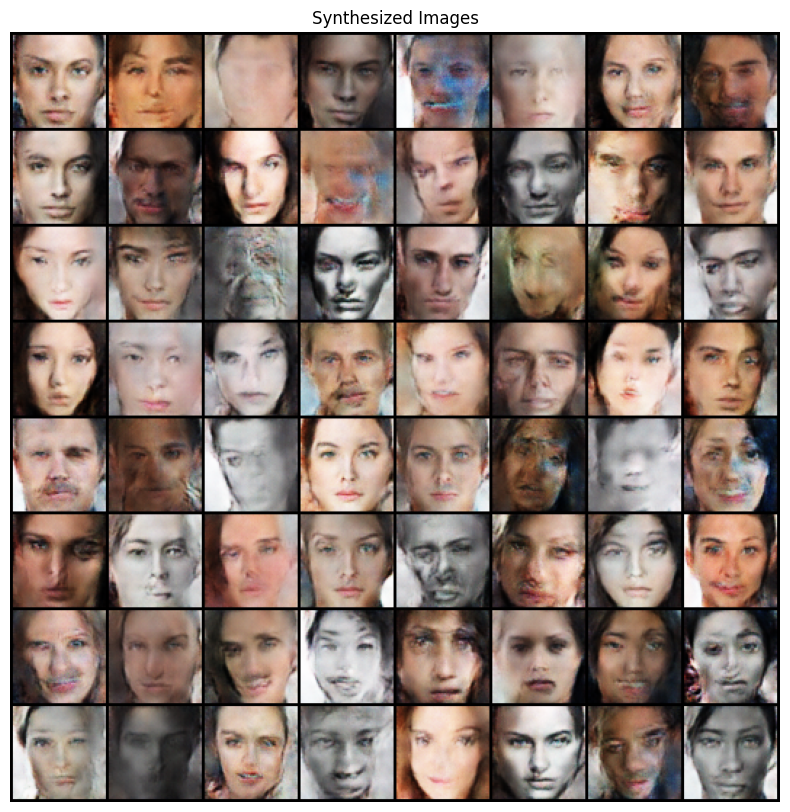

In [ ]:
class Preprocessor:
    def __init__(self, fileid = '1vih3dBJj5vK1NJBrhaN5pkrIbn2LMAjf'):
        self.fileid = fileid
        self.url = f'https://drive.google.com/uc?id={self.fileid}'
        self.targetfolder = '/content/'
        self.zipFile = 'Male_Female_Faces.zip'
        # Crop images to retain only faces and discard other details
        self.face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        self.croped_faces = !mkdir croped_faces

    def Dataset(self):
        gdown.download(self.url, self.zipFile, quiet=False)
        if not os.path.exists(self.targetfolder):
            os.makedirs(self.targetfolder)
    def unzip(self):
        with zipfile.ZipFile(self.zipFile, 'r') as zipref:
            zipref.extractall(self.targetfolder)
            print(f'Dataset downloaded and extracted to {self.targetfolder} successfully!')
    def removezip(self):
        os.remove(self.zipFile)
        print(f'Compressed file {self.zipFile} removed!')

    # Apply face croping and store all croped images into croped_faces folder
    def ApplyCrop(self):
        images =Glob('/content/Male_Femal_Faces/Female_Faces/*.jpg')+Glob('/content/Male_Femal_Faces/Male_Faces/*.jpg')
        print("\nBuilding Cropped Dataset ....")
        for i in Tqdm(range(len(images))):
            img = read(images[i],1)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            faces = self.face_cascade.detectMultiScale(gray, 1.3, 5)
            for (x,y,w,h) in faces:
                img2 = img[y:(y+h),x:(x+w),:]
            cv2.imwrite('croped_faces/'+str(i)+'.jpg',cv2.cvtColor(img2, cv2.COLOR_RGB2BGR))
    def run(self):
        self.Dataset()
        self.unzip()
        self.removezip()
        self.ApplyCrop()

# Class to read croped dataset from folder
class Faces(Dataset):
    def __init__(self, folder):
        self.folder = folder
        self.images = sorted(Glob(folder))
    def __len__(self): return len(self.images)
    def __getitem__(self,xi):
        image_path = self.images[xi]
        image = Image.open(image_path)
        image = self.ImageTransform(image)
        return image
    def ImageTransform(self,img):
        transform = transforms.Compose([
            transforms.Resize(64),
            transforms.CenterCrop(64),
            transforms.ToTensor(),
            transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) ])
        return transform(img)

class Models:
    # Take input image of size batchsize x 3 x 64 x 64 and predicts (real or fake)
    class Discriminator(nn.Module):
        def __init__(self):
            super(Models.Discriminator, self).__init__()
            self.model = nn.Sequential(

                # Initial convolution (downsample)
                nn.Conv2d(3, 64, 4,2,1,bias=False),
                nn.LeakyReLU(0.2, inplace=True),

                # Downsample to 128 feature maps
                nn.Conv2d(64,64*2, 4,2,1, bias=False),
                nn.BatchNorm2d(64*2),
                nn.LeakyReLU(0.2, inplace=True),

                # Downsample to 256 feature maps
                nn.Conv2d(64*2, 64*4, 4,2,1, bias=False),
                nn.BatchNorm2d(64*4),
                nn.LeakyReLU(0.2, inplace=True),

                # Downsample to 512 feature maps
                nn.Conv2d(64*4, 64*8, 4,2,1, bias=True),
                nn.BatchNorm2d(64*8),
                nn.LeakyReLU(0.2, inplace=True),

                # Output layer (real/fake)
                nn.Conv2d(64*8, 1,4,1,0, bias=False),
                nn.Sigmoid() )
            self.apply(self.init_weights)
        def forward(self, input): return self.model(input)
        # Control weight spread
        def init_weights(self,m):
            classname = m.__class__.__name__
            if classname.find('conv') != -1:
                nn.init.normal_(m.weight.data,0.0,0.02) # Normal Distribut: mean=0.0 & std=0.02
            elif classname.find('BatchNorm') != -1:
                nn.init.normal_(m.weight.data, 1.0, 0.02)
                nn.init.constant_(m.bias.data,0)
    # Generate Fake Images from input of shape batchsize x 100 x 1 x 1
    class Generator(nn.Module):
        def __init__(self):
            super(Models.Generator,self).__init__()
            self.model = nn.Sequential(

                # Latent vector to 512 feature maps
                nn.ConvTranspose2d(100, 64*8, 4,1,0, bias=False), # gradually upsampling
                nn.BatchNorm2d(64*8),
                nn.ReLU(True),

                # Upsample to 256 feature maps
                nn.ConvTranspose2d(64*8, 64*4, 4,2,1, bias=False),
                nn.BatchNorm2d(64*4),
                nn.ReLU(True),

                # Upsample to 128 feature maps
                nn.ConvTranspose2d(64*4, 64*2, 4,2,1, bias=False),
                nn.BatchNorm2d(64*2),
                nn.ReLU(True),

                # Upsample to 64 feature maps
                nn.ConvTranspose2d(64*2, 64, 4,2,1, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(True),

                # Final upsample to 3 channels (RGB)
                nn.ConvTranspose2d( 64,3,4,2,1,bias=False),
                nn.Tanh() )
            self.apply(self.init_weights)
        def forward(self,input): return self.model(input)
        def init_weights(self,m):
            classname = m.__class__.__name__
            if classname.find('conv') != -1:
                nn.init.normal_(m.weight.data,0.0,0.02) # Normal Distribut: mean=0.0 & std=0.02
            elif classname.find('BatchNorm') != -1:
                nn.init.normal_(m.weight.data, 1.0, 0.02)
                nn.init.constant_(m.bias.data,0)
    def Model_Summary(self):
        Discriminator = self.Discriminator().to(device)
        Generator = self.Generator().to(device)
        print('\nDiscriminator Model Summary:\n')
        summary(Discriminator,input_size=(3,64,64))
        print('\nGenerator Model Summary:')
        summary(Generator, input_size=(100,1,1))

class TrainModels:
    def __init__(self, dataloader):
        self.dataloader = dataloader
        # Model Objects
        self.disc_model = Models.Discriminator().to(device)
        self.gen_model = Models.Generator().to(device)
        # Optimizers
        self.disc_optimizer = optim.Adam(self.disc_model.parameters(), lr=0.0002, betas=(0.5,0.999))
        self.gen_optimizer = optim.Adam(self.gen_model.parameters(), lr=0.0002, betas=(0.5,0.999))
        # Loss
        self.loss = nn.BCELoss()
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

    def Train_discriminator(self,real_data, fake_data):
        self.real_data = real_data
        self.disc_optimizer.zero_grad()
        real_prediction = self.disc_model(real_data)
        real_error = self.loss(real_prediction.squeeze(), torch.ones(len(real_data)).to(self.device))
        real_error.backward()
        fake_prediction = self.disc_model(fake_data)
        fake_error = self.loss(fake_prediction.squeeze(), torch.zeros(len(fake_data)).to(self.device))
        fake_error.backward()
        self.disc_optimizer.step()
        return real_error+fake_error

    def Train_generator(self,fake_data):
        self.gen_optimizer.zero_grad()
        pred = self.disc_model(fake_data)
        error = self.loss(pred.squeeze(),torch.ones(len(self.real_data)).to(self.device))
        error.backward()
        self.gen_optimizer.step()
        return error
    def Trainer(self):
        log = Report(150)
        print('\nTraining Started ... \n')
        for epoch in range(150):
            K = len(self.dataloader)
            #Load Real Data Images and process
            for i, images in enumerate(self.dataloader):
                real_data = images.to(self.device)
                fake_data = self.gen_model(torch.randn(len(real_data),100,1,1).to(self.device)).to(self.device)
                fake_data = fake_data.detach()
                disc_loss = self.Train_discriminator(real_data,fake_data)
                fake_data = self.gen_model(torch.randn(len(real_data),100,1,1).to(self.device)).to(self.device)
                gen_loss = self.Train_generator(fake_data)
                log.record(epoch+(1+i)/K, disc_loss = disc_loss.item(), gen_loss=gen_loss.item(), end='\r')
            log.report_avgs(epoch+1)
        log.plot_epochs(['disc_loss','gen_loss'])
    def eval_unseen(self):
        self.gen_model.eval()
        noise = torch.randn(64,100,1,1, device=self.device)
        sample_images = self.gen_model(noise).detach().cpu()
        grid = vutils.make_grid(sample_images,nrow=8, normalize=True)
        show(grid.cpu().detach().permute(1,2,0), sz=10, title='Synthesized Images')

if __name__ == '__main__':
    # Download and Prepare Dataset
    downloaddata = Preprocessor()
    downloaddata.run()

    # Faces Dataset Object
    FacesDataset = Faces(folder='/content/croped_faces/')
    Dataloaders = DataLoader(FacesDataset, batch_size=64, shuffle=True, num_workers=8)

    # Models Summary
    models = Models()
    models.Model_Summary()
    #Trainers
    trainmodels = TrainModels(Dataloaders)
    trainmodels.Trainer()
    trainmodels.eval_unseen()


The images are decent, but they still lack sufficient realism and we have fluctuations in loss graph. One possible reason is that the face alignment across all input images is not consistent, we might have provided less training dataset or network need more training time so we might need to train for longer time for better results!" it looks like we've unintentionally created some zombie-like faces! 😀"